In [ ]:
#default_exp finance.data

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#add the parent directiry so thatwecan access modules the and inits subdirectories
import sys, os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir  = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [ ]:
# export
from lib.data.lists import *
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [ ]:
# Version of the SimFin Python API.
sf.__version__

'0.8.1'

# Load shareprices

In [ ]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')
dataPath = Path.home()/"simfin_data"
print(f"dataPath:{dataPath} exists:{dataPath.exists()}")


dataPath:/Users/kasparlund/simfin_data exists:True


In [ ]:
%%time
# Data for USA.
market = 'us'
# Daily Share-Prices.
df_prices = sf.load_shareprices(variant='daily', market=market)

Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 26.4 s, sys: 1.57 s, total: 27.9 s
Wall time: 27.9 s


In [ ]:
df_prices.head()

SimFinId   Open    Low   High  Close  Adj. Close  Dividend  \
Ticker Date                                                                     
A      2007-01-03     45846  34.99  34.05  35.48  34.30       22.69       NaN   
       2007-01-04     45846  34.30  33.46  34.60  34.41       22.76       NaN   
       2007-01-05     45846  34.30  34.00  34.40  34.09       22.55       NaN   
       2007-01-08     45846  33.98  33.68  34.08  33.97       22.47       NaN   
       2007-01-09     45846  34.08  33.63  34.32  34.01       22.50       NaN   

                    Volume  Shares Outstanding  
Ticker Date                                     
A      2007-01-03  2574600                 NaN  
       2007-01-04  2073700                 NaN  
       2007-01-05  2676600                 NaN  
       2007-01-08  1557200                 NaN  
       2007-01-09  1386200                 NaN

# Prepare data for prediction of stock proces the next day
Create OHLC price changes as percentages relative to the close of the previous day. Furthermore the ohlc is supplemented by the previous days closing.

In [ ]:
%%time
# Make a new column to show the closing price from the previous day on the same line as current day. 
# This is done using the shift function for the dataserie
# 
# Result: All stock and prices are listed in the same tabel. Therefore, the firat priceline of each stock vil now 
# contain the close of the previous stock. For the first stock this value vil be "nan". 
# These incoherent pricelines are removed in the nest step
PREV_CLOSE = "previous_close"
df_prices.insert(df_prices.columns.get_loc(OPEN), PREV_CLOSE, df_prices[CLOSE].shift(), allow_duplicates=False)

#identify the first stock in each stockgroup and the remove it
stock_name    = df_prices.index.get_level_values(0)
new_stock     = np.ones(len(df_prices), dtype=bool)
new_stock[1:] = stock_name[0:len(stock_name)-1] != stock_name[1:len(stock_name)]
df_prices.drop(df_prices.index[new_stock], axis=0, inplace=True)
df_prices

CPU times: user 42.3 s, sys: 1.09 s, total: 43.4 s
Wall time: 43.5 s


SimFinId  previous_close   Open    Low   High  Close  \
Ticker Date                                                               
A      2007-01-04     45846           34.30  34.30  33.46  34.60  34.41   
       2007-01-05     45846           34.41  34.30  34.00  34.40  34.09   
       2007-01-08     45846           34.09  33.98  33.68  34.08  33.97   
       2007-01-09     45846           33.97  34.08  33.63  34.32  34.01   
       2007-01-10     45846           34.01  34.04  33.37  34.04  33.70   
...                     ...             ...    ...    ...    ...    ...   
ZYXI   2020-06-01    171401           19.40  19.45  19.34  20.13  19.70   
       2020-06-02    171401           19.70  19.75  19.03  19.97  19.57   
       2020-06-03    171401           19.57  19.54  18.77  20.68  19.99   
       2020-06-04    171401           19.99  20.01  19.12  20.55  19.44   
       2020-06-05    171401           19.44  19.41  19.41  21.96  21.43   

                   Adj. Close  Dividend   Volume  Shares Outstanding  
Ticker Date                                                           
A      2007-01-04       22.76       NaN  2073700                 NaN  
       2007-01-05       22.55       NaN  2676600                 NaN  
       2007-01-08       22.47       NaN  1557200                 NaN  
       2007-01-09       22.50       NaN  1386200                 NaN  
       2007-01-10       22.29       NaN  2157400                 NaN  
...                       ...       ...      ...                 ...  
ZYXI   2020-06-01       19.70       NaN   849450          33192517.0  
       2020-06-02       19.57       NaN   559359          33192517.0  
       2020-06-03       19.99       NaN   956286          33192517.0  
       2020-06-04       19.44       NaN   697397          33192517.0  
       2020-06-05       21.43       NaN  1150522          33192517.0  

[6843406 rows x 10 columns]

In [ ]:
%time df_prices[[OPEN,CLOSE,LOW,HIGH]] = df_prices[[OPEN,CLOSE,LOW,HIGH]].sub(df_prices[PREV_CLOSE],axis=0)\
                                        .div(df_prices[PREV_CLOSE],axis=0)
df_prices

CPU times: user 295 ms, sys: 238 ms, total: 532 ms
Wall time: 535 ms


SimFinId  previous_close      Open       Low      High  \
Ticker Date                                                                 
A      2007-01-04     45846           34.30  0.000000 -0.024490  0.008746   
       2007-01-05     45846           34.41 -0.003197 -0.011915 -0.000291   
       2007-01-08     45846           34.09 -0.003227 -0.012027 -0.000293   
       2007-01-09     45846           33.97  0.003238 -0.010009  0.010303   
       2007-01-10     45846           34.01  0.000882 -0.018818  0.000882   
...                     ...             ...       ...       ...       ...   
ZYXI   2020-06-01    171401           19.40  0.002577 -0.003093  0.037629   
       2020-06-02    171401           19.70  0.002538 -0.034010  0.013706   
       2020-06-03    171401           19.57 -0.001533 -0.040879  0.056719   
       2020-06-04    171401           19.99  0.001001 -0.043522  0.028014   
       2020-06-05    171401           19.44 -0.001543 -0.001543  0.129630   

                      Close  Adj. Close  Dividend   Volume  Shares Outstanding  
Ticker Date                                                                     
A      2007-01-04  0.003207       22.76       NaN  2073700                 NaN  
       2007-01-05 -0.009300       22.55       NaN  2676600                 NaN  
       2007-01-08 -0.003520       22.47       NaN  1557200                 NaN  
       2007-01-09  0.001178       22.50       NaN  1386200                 NaN  
       2007-01-10 -0.009115       22.29       NaN  2157400                 NaN  
...                     ...         ...       ...      ...                 ...  
ZYXI   2020-06-01  0.015464       19.70       NaN   849450          33192517.0  
       2020-06-02 -0.006599       19.57       NaN   559359          33192517.0  
       2020-06-03  0.021461       19.99       NaN   956286          33192517.0  
       2020-06-04 -0.027514       19.44       NaN   697397          33192517.0  
       2020-06-05  0.102366       21.43       NaN  1150522          33192517.0  

[6843406 rows x 10 columns]

In [ ]:
df_prices[[PREV_CLOSE,OPEN,CLOSE,LOW,HIGH]].describe(percentiles=[0.0002, 0.25, 0.75, 0.9998])

,previous_close,Open,Close,Low,High
count,6.823644e+06,6.823293e+06,6.823243e+06,6.822915e+06,6.823450e+06
mean,3.434526e+04,2.525271e-02,2.572381e-02,6.438691e-03,4.423030e-02
std,1.752721e+06,8.331265e+00,8.302968e+00,8.212239e+00,8.411199e+00
min,1.000000e-02,-9.998592e-01,-9.998972e-01,-9.998985e-01,-9.998357e-01
0.02%,1.000000e-02,-5.882353e-01,-5.473984e-01,-6.623294e-01,-5.000000e-01
25%,1.176000e+01,-4.065041e-03,-1.118807e-02,-2.432046e-02,3.402647e-03
50%,2.618000e+01,0.000000e+00,0.000000e+00,-1.111111e-02,1.112782e-02
75%,5.077000e+01,4.746785e-03,1.151874e-02,-3.062787e-03,2.368030e-02
99.98%,1.000000e+08,1.116000e+00,1.214540e+00,1.000000e+00,1.747562e+00
max,1.000000e+08,6.924000e+03,7.005250e+03,6.900250e+03,7.021500e+03


In [ ]:
seq_length          = 30  #dage
minimum_tradingdays = 180 #dage 
stock_grps          = df_prices.groupby(["Ticker"])
stocks              = np.array(list(stock_grps.groups))
stock_days          = np.zeros(len(stocks),dtype=int)
sizes               = stock_grps.size()
bdx_immature_stocks = (sizes <= minimum_tradingdays).values
bdx_mature_stocks   = (sizes > minimum_tradingdays).values
stocks              = np.array(list(stock_grps.groups))

print(f"number of stocks:          {len(stocks)}")
print(f"number of immature_stocks: {sum(bdx_immature_stocks)}")
print(f"number of mature_stocks:   {sum(bdx_mature_stocks)}")
print(f"smallest pricelines pr stock: {sizes.sort_values()[:25]}")
print(f"longest pricelines pr stock:  {sizes.sort_values()[-10:]}")

number of stocks:          2615
number of immature_stocks: 31
number of mature_stocks:   2584
smallest pricelines pr stock: Ticker
NLN        1
WMG        2
SSI       17
GAMZ      18
PCP       24
BRCM      25
CYRP      26
GEPC      29
FTRCQ     30
MENI      38
MSGE      39
JGPK      42
ARNC      45
OTIS      54
CARR      54
CWRL      55
CSPR      83
FLLC      86
ONEM      87
PRCH     100
BATL     112
SKPN     123
CPXX     132
BRMK     138
NUZE     145
dtype: int64
longest pricelines pr stock:  Ticker
HURC    3379
HUN     3379
HUM     3379
HTZ     3379
HTLD    3379
HTH     3379
HT      3379
HSY     3379
HST     3379
KBR     3379
dtype: int64


In [ ]:
#remove mature stocks with "nan" prices

ix_cols  = [df_prices.columns.get_loc(k) for k in [PREV_CLOSE,OPEN,LOW,HIGH,CLOSE] ]

#extrem_stocks,extrem_increase,extrem__decrease = [], 2.5, -.73
extrem_stocks,extrem_increase,extrem__decrease = [], 1.5, -.5
for idx,(name,group) in enumerate(stock_grps):
    group_has_nan = group[[OPEN,LOW,HIGH,CLOSE]].isnull().values.any()
    stock_days[idx] = len(group)
    if group_has_nan:
        #print(f"idx:{idx} name:{name}")
        bdx_mature_stocks[idx] = False
        bdx_immature_stocks[idx] = True
    #elif group[[OPEN,LOW,HIGH,CLOSE]].gt(extrem_increase).any().any() or  group[[OPEN,LOW,HIGH,CLOSE]].lt(extrem__decrease).any().any():
    elif group[[OPEN,LOW,HIGH,CLOSE]].gt(extrem_increase).any().any() or  group[[OPEN,LOW,HIGH,CLOSE]].lt(extrem__decrease).any().any():
        extrem_stocks.append(name)
        bdx_mature_stocks[idx] = False
        bdx_immature_stocks[idx] = True
        
    
print(f"number of stocks:          {len(stocks)}")
print(f"number of immature_stocks: {sum(bdx_immature_stocks)}")
print(f"number of mature_stocks:   {sum(bdx_mature_stocks)}")
print(f"number of extrem_stocks:   {len(extrem_stocks)}\n{extrem_stocks}")
stock_days

number of stocks:          2615
number of immature_stocks: 583
number of mature_stocks:   2032
number of extrem_stocks:   492
['AAME', 'ABCD', 'ABEO', 'ABIO', 'ABMC', 'ABT', 'ABTL', 'ABUS', 'ACAD', 'ACER', 'ACET', 'ACET_delis', 'ACHC', 'ACLS', 'ACRX', 'ADES', 'ADIL', 'ADPT_delis', 'ADVM', 'ADXS', 'AEHR', 'AGO', 'AGS', 'AHPI', 'AIG', 'AIRI', 'AJX', 'AKER', 'AKRX', 'ALPN', 'ALRN', 'ALT', 'AMAT', 'APA', 'APPS', 'APRN', 'ARCW', 'ARNA', 'ARO', 'ARQL', 'ARWR', 'ASH', 'ASTC', 'ATSR', 'AVEO', 'AVGR', 'AVNW', 'AVXL', 'AWH', 'AXGN', 'AXL', 'AXN', 'BATL', 'BBBI', 'BBSI', 'BCEI', 'BCOR', 'BEBE', 'BERK', 'BGS', 'BHC', 'BHR', 'BKTI', 'BLFS', 'BMRA', 'BONT', 'BOXL', 'BRS', 'BSPM', 'BSTG', 'CALL', 'CAPC', 'CAR', 'CBKCQ', 'CBM', 'CCXI', 'CELH', 'CENT', 'CETV', 'CETX', 'CFMS', 'CGA', 'CHAP', 'CHEF', 'CIDM', 'CLBS', 'CLNY', 'CLR', 'CLRB', 'CLSK', 'CMLS', 'CNND', 'CNXR', 'CODA', 'CORR', 'CORT', 'COT', 'CPE', 'CPXX', 'CRAWA', 'CRDF', 'CROX', 'CRVS', 'CSBR', 'CSC', 'CSLT', 'CTIC', 'CTXR', 'CWS', 'CXW', 'CY'

array([3379,  903, 3379, ..., 2805, 1217, 3377])

In [ ]:
#len(df_prices), len(df_prices[stocks[bdx_mature_stocks]]), len(stocks[bdx_mature_stocks])
#[[PREV_CLOSE,OPEN,CLOSE,LOW,HIGH]].describe(percentiles=[0.0002, 0.25, 0.75, 0.9998])
#len(stocks),len(bdx_mature_stocks), type(stocks),type(bdx_mature_stocks),bdx_mature_stocks.sum()
#len(stocks[bdx_mature_stocks])
sum(stock_days), len(df_prices), len(df_prices.loc[stocks[bdx_mature_stocks]]), len(df_prices.loc[stocks[bdx_mature_stocks]])/len(df_prices)*100
#df_prices.loc["ABMC"]

(6843406, 6843406, 5452634, 79.67719582909446)

# Statics on the mature stocks
 - min, max, mean, std, percentiles
 - calculate the normalization numbers


# Create dataset
The dataset must a batch with number of stock = batch_size  
Each sequence of stockprice (ohlc) return from the dataset must be of the samme sequence_length
During the training the network will process the sequence day by day

At the beginning of each epoch
    It must be possible to shuffle the stock 
    It must be possible to shuffle the start date of the stockprices for each stock 

The dataframe will remain fixed during the training using indirect indexing 
This will be faster and use less memory for large dataframes.


In [ ]:
np.array( np.random.random_sample(len(stocks))*(stock_days-seq_length-1) + .5, dtype=int ).sum()*2+(seq_length+1)*len(stock_days)

6895109

In [ ]:
# export
import torch
from lib.data.lists import *
torch.set_default_dtype(torch.float64)

#Create a dataset that uses all the stocks and daily prices during one epoch
#an epoch starts by choosing a new set of stocks at random.

#stocks    : are the stock tickers
#stock_days: is the number of days pr stock. The number of days is in different for each stock
#            The total number of samples is stock_days.sum()
#batch_size: is the number of stocks in a batch
#seq_length: is the number of stocks days in a batch

#The length of the dataset is: stock_days.sum() / (batch_size*sequence_length) rounded to the nearest integer.

#When the offset+seq_length+1 exceeds the number of days in the stock then the sequences is
#restarted at 0 or a random offset 
#
#As for now the dataset progress sequentially through the data during an epoch from a random offset. 
#Notice that there is no end of sequence-token to reset the model when the sequencen wraps around
#

class OHLCDataset(torch.utils.data.Dataset):
    #x, y significes input vs output
    def __init__(self, df_prices, stocks, stock_days, batch_size, seq_length): 
        self.df_prices   = df_prices
        self.stock_grps  = self.df_prices.groupby(["Ticker"])
        self.stocks      = np.array(list(self.stock_grps.groups)) if stocks is None else stocks
        self.stock_days  = stock_days
        self.seq_length  = seq_length
        #seq_start: The index to the start of the first priceline is shuffled when the batch starts.
        #seq_start moves forward at each call of gettime.
        #when seq_start+seq_length reach the last priceline for the stock then seq_start is reset to the stock´ 
        #first priceline 
        self.seq_start   = None 
        self.ix_columns = [self.df_prices.columns.get_loc(k) for k in [OPEN,LOW,HIGH,CLOSE]]

    def __len__(self): return len(self.stocks)
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (xt, yt, index) where 
                xt is a tensor with at squence of pricelines, 
                yt is the priceline to be predicted 
                index is the index of xt and yt in the dataset 
        """
        self.initializeSquenzing()
        stock = self.stocks[index]
        grp   = self.stock_grps.get_group(stock)
        if self.seq_start is None : 
            self.initializeSquenzing()
        elif self.seq_start[index] + self.seq_length >= len(grp)-1:
            self.seq_start[index] = 0
        
        ib,ie          = self.seq_start[index], self.seq_start[index]+self.seq_length
        price_sequence = torch.tensor(grp.iloc[ib:ie, self.ix_columns].to_numpy())
        price_target   = torch.tensor(grp.iloc[ie,    self.ix_columns].to_numpy())
        self.seq_start[index] += 1
        #return price_sequence, price_target, index
        return price_sequence, price_target
     
    def initializeSquenzing(self):
        #self.seq_start  = (self.stock_days-(seq_length+1)) * np.random.random_sample(len(stocks))
        #randomize the start og the sequence in the interval 0 to the number og day minus the sequence_length
        #The "minus the sequence_length" is due to the wrap around at "self.seq_length >= len(grp)-1"
        rands = np.random.random_sample(len(self))*(self.stock_days-self.seq_length-1)
        self.seq_start  = np.array( rands + .5, dtype=int )
        
        
    def dataloader(self, batch_size:int, shuffle:bool, num_workers:int=0):
        return torch.utils.data.DataLoader(self, batch_size=batch_size, shuffle=shuffle,
                                           num_workers=num_workers, drop_last=True)
    
    def split2train_test(self, test_percentage):
        #split the stocklist in train and test datasets
        ix_all   = np.arange(len(self),dtype=int)
        np.random.shuffle(ix_all)
        
        nb_test  = int(round(test_percentage*len(self)))
        ix_train = ix_all[nb_test:]
        ix_test  = ix_all[:nb_test]
        
        print(len(self.stocks[ix_train]))
        print(len(self.stocks[ix_test]))
        print(len(self.stock_days[ix_train]))
        print(len(self.stock_days[ix_test]))
        return OHLCDataset(self.df_prices, self.seq_length, stocks=self.stocks[ix_train], stock_days=self.stock_days[ix_train]), \
               OHLCDataset(self.df_prices, self.seq_length, stocks=self.stocks[ix_test],  stock_days=self.stock_days[ix_test])

ohlc_ds = OHLCDataset(df_prices,seq_length=30,\
                      stocks=stocks[bdx_mature_stocks], stock_days=stock_days[bdx_mature_stocks])
train_ds, test_ds = ohlc_ds.split2train_test(0.25)
print(f"number of stocks, train stocks, test stocks: {len(ohlc_ds)}, {len(train_ds)}, {len(test_ds)}")

#each priceline has 4 datapoint:[OPEN,LOW,HIGH,CLOSE]
#batchsize is the number of stocks that is processe in parallel

#ohlc almost alla day to day variation are in the the range -1 to 1.
#For now we do not normalize the input. However we will have to do it sooner or later

databunch = DataBunch(train_ds.dataloader(batch_size=256, shuffle=True), \
                      test_ds.dataloader( batch_size=256, shuffle=False), \
                      c_in=4, c_out=4)

batch = next(iter(databunch.train_dl))
view = view_tfm(4,seq_length)
batch[0].dtype, batch[0].shape, view(batch[0]).shape

1524
508
1524
508
number of stocks, train stocks, test stocks: 2032, 1524, 508


(torch.float64, torch.Size([256, 30, 4]), torch.Size([256, 4, 30]))

In [ ]:
#for idx,b in enumerate(databunch.train_dl): 
#    print(f"idx,len of input and output tensor {idx} {len(b[0])}  {len(b[1])}")

# Create a nn.model
We start by a regressionnmodel that predict the next OHLC
 - First try will be the to minimize the squared sum of errors.

In [ ]:
def conv1(ni, nf, ks=3, stride=1, bias=False, dropout_ratio=0.25):
    if dropout_ratio > 0. :
        #return [ torch.nn.Dropout(p=dropout_ratio, inplace=False),
        #         torch.nn.Conv1d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)]
        return [ torch.nn.Conv1d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias),
                 torch.nn.Dropout(p=dropout_ratio, inplace=False) ]
    else:                    
        return [torch.nn.Conv1d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)]


def conv_layer1(ni, nf, ks, stride, bn, zero_bn, act, dropout_ratio=0.15):
    #ni:      number of input filters
    #nf:      number of output filteres
    #ks:      kernel size
    #act:     activation function : nn.ReLU, nn.reLU
    #bn:      create batchnorm layer
    #zero_bn: init bias and weright in batchnorm to zero
    layers = [*conv1(ni, nf, ks, stride=stride, dropout_ratio=dropout_ratio)]
    #"""
    if bn: 
        bnorm = nn.BatchNorm1d(nf)
        nn.init.constant_(bnorm.weight, 0. if zero_bn else 1.)
        layers.append(bnorm)
    #"""
    if act is not None: 
        #layers.append(torch.nn.Dropout(p=dropout_ratio, inplace=False))
        layers.append(act())
    return nn.Sequential(*layers)

def get_cnn_layers1(n_filters_pr_layer,  input_features, output_features, layer, **kwargs):
    print("get_cnn_layers")
    
    nfs = [input_features] + n_filters_pr_layer
    print(f"channels pr layers from input to output: {nfs+[output_features]}")

    in2hidden_layers     = [layer(nfs[i], nfs[i+1], ks=(5 if i==0 else 3), **kwargs) for i in range(len(nfs)-1)] 
    print(f"number of input and hidden layers: {len(in2hidden_layers)}")

    hidden2output_layers = [nn.AdaptiveAvgPool1d(1), Lambda(flatten), nn.Linear(nfs[-1], output_features)]
    print(f"number of output layers :          {len(hidden2output_layers)}")

    all_layers = in2hidden_layers + hidden2output_layers
    print(f"total number of layers:            {len(all_layers)}")
    return all_layers
    #return [layer(nfs[i], nfs[i+1], ks=(5 if i==0 else 3), **kwargs) for i in range(len(nfs)-1)] + \
    #       [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], output_features)]

def get_cnn_model1(filters_pr_layer,  input_features,  output_features, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers1(filters_pr_layer,  input_features, output_features, layer, **kwargs))
    

In [ ]:
from functools import partial
from lib.learner.learner import*
from lib.learner.optimizers import*
from lib.model.model import*
from lib.model.modelmanager import*
import torch.nn as nn

layers_sizes = [64,64,128,256]
layer = partial( conv_layer1, stride=1, bn=False, zero_bn=False, act=GeneralRelu )
mm    = CnnModelManager( get_cnn_model1(layers_sizes, databunch.c_in, databunch.c_out, layer ) )
mm.initialize(is_resnet=False)

tensor_input_view = view_tfm(4,seq_length)

xb,_ = mm.getFirstbatch( databunch, normalization = tensor_input_view)
print(f"input shape:{xb.shape}")
mm.summary(xb, print_mod=False)

get_cnn_layers
channels pr layers from input to output: [4, 64, 64, 128, 256, 4]
number of input and hidden layers: 4
number of output layers :          3
total number of layers:            7
input shape:torch.Size([256, 4, 30])
<class 'torch.nn.modules.conv.Conv1d'> torch.Size([256, 64, 30])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([256, 64, 30])
<class 'lib.model.model.GeneralRelu'> torch.Size([256, 64, 30])
<class 'torch.nn.modules.conv.Conv1d'> torch.Size([256, 64, 30])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([256, 64, 30])
<class 'lib.model.model.GeneralRelu'> torch.Size([256, 64, 30])
<class 'torch.nn.modules.conv.Conv1d'> torch.Size([256, 128, 30])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([256, 128, 30])
<class 'lib.model.model.GeneralRelu'> torch.Size([256, 128, 30])
<class 'torch.nn.modules.conv.Conv1d'> torch.Size([256, 256, 30])
<class 'torch.nn.modules.dropout.Dropout'> torch.Size([256, 256, 30])
<class 'lib.model.model.GeneralRelu'> 

# Regression loss

In [ ]:
def my_mse_loss(t_in, t_target):
    #print(f"t_in : {t_in.dtype} {t_in.shape} ")
    #print(f"t_target : {t_target.dtype} {t_target.shape} ")
    ret = (t_in-t_target).square().mean()
    #print(ret)
    return ret

sched        = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs         = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
#                partial(CudaCallback, device= torch.device('cuda',0)),
#                partial(ParamScheduler, 'lr', sched),
                partial(BatchTransformXCallback, tfm = tensor_input_view), 
#                partial(MixUp,α=0.4),
#                LR_Finder,
                
                Recorder, 
#                partial(AvgStatsCallback,[accuracy]),
#                partial(AvgStatsCallback,[my_mse_loss]),
                partial(AvgStatsCallback,[torch.nn.functional.mse_loss]),
#                partial(AvgStatsCallback,[torch.nn.functional.smooth_l1_loss]),
                ProgressCallback
               ]

In [ ]:
opt       = SGD(sched,max_lr=0.1)
loss_func = torch.nn.MSELoss()
#loss_func = torch.nn.SmoothL1Loss()

#loss_func = my_mse_loss 

learn = Learner( mm.model, databunch, loss_func=loss_func)
%time learn.fit(25, opt=opt, cb_funcs=cbfs)

epoch,train_loss,train_mse_loss,valid_loss,valid_mse_loss,time
0,0.002558,0.002558,0.002470,0.002470,00:02
1,0.002338,0.002338,0.001926,0.001926,00:02
2,0.002148,0.002148,0.002240,0.002240,00:02
3,0.001745,0.001745,0.001720,0.001720,00:02
4,0.001716,0.001716,0.002873,0.002873,00:02
5,0.001454,0.001454,0.001130,0.001130,00:02
6,0.001094,0.001094,0.001024,0.001024,00:02
7,0.001194,0.001194,0.001054,0.001054,00:02
8,0.000958,0.000958,0.000926,0.000926,00:02
9,0.000618,0.000618,0.000636,0.000636,00:02


CPU times: user 3min 10s, sys: 15.2 s, total: 3min 26s
Wall time: 1min 2s


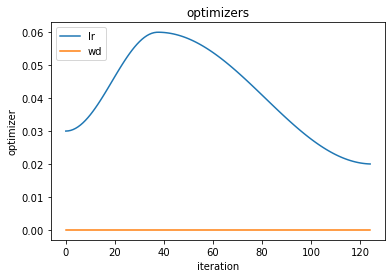

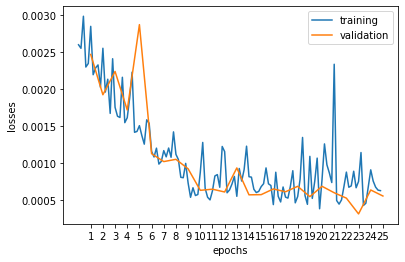

(None, None)

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(skip_start=0),plt.show()